In [33]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn

# Attention-based Evaluation of Self-Supervised Embeddings

The theory behind using attention is simple: not every tile in a slide is useful for scoring Braak. An attention mechanism will selectively weight different tiles in a slide to increase or decrease their impact on the classifiers decision. In a sense, linear regression is performing 'attention' over the attributes of a data set to determine which ones most heavily influence the outcome. 

Our implementation of attention occurs at the pooling stage, where all of the tile embeddings in a slide (ranging in number from 10,000 to 25,000) are combined into a single feature vector. Until recently, the most common technique to do this was simply average pooling each feature over the entire slide. However, attention will weight each tile individually before pooling, allowing for selection of the most impactful tiles. Our method follows these steps:

1. Reduce the dimensionality of the feature space from 2048 (x) to 384 (h) through a series of fully connected layers.
2. Compute 2 separate attention mechanisms over the reduced feature space h (attention_a and attention_b)
    - a and b are essentially the same, apart from their activation functions. It has been fairly common to use multiple different attention heads to avoid any deleterious effects of one vs the other
3. Multiply the two attention mechanisms together before passing them through a final fully connected layer which reduces the attention to a vector of size (1, # tiles). This is the final attention vector ready to weight the tiles.
4. Take the softmax of the attention vector to normalize its weighting. 
5. Multiply the transpose of the attention vector with the tile feature matrix to receive a 1xh representative pooling of the entire slide. 
6. Train an ordinal regression model with this pooled feature vector.

We are using CORAL regression in our experiments due to the nature of Braak scores. Given than Braak is an ordinal, discrete scale, we thought it best to not use a typical classification method like logistic regression, as it will not fully capture the ordinality of our data. The model, with comments is included below.

In [ ]:
# Attention + ordinal regression model.
class BRAAK_attention(nn.Module):
    def __init__(self, gate=True, L=2048, size="big", dropout=False, n_classes=5):
        super(BRAAK_attention, self).__init__()
        
        # setup of the dimensions of the model        
        self.size_dict = {"small": [L, 512, 256], "big": [L, 512, 384]}
        size = self.size_dict[size]
        
        # setup of the linear feature-reduction layer
        fc = [nn.Linear(size[0], size[1]), nn.ReLU()]
        if dropout:
            fc.append(nn.Dropout(0.25))
        self.fc = nn.Sequential(*fc)
        
        # attention head setup
        self.attention_a = [nn.Linear(size[1], size[2]), nn.Tanh()]            
        self.attention_b = [nn.Linear(size[1], size[2]), nn.Sigmoid()]            
        if dropout:
            self.attention_a.append(nn.Dropout(0.25))
            self.attention_b.append(nn.Dropout(0.25))
        self.attention_a = nn.Sequential(*self.attention_a)
        self.attention_b = nn.Sequential(*self.attention_b)
        self.attention_c = nn.Linear(size[2], 1)
        
        # final classification layer
        self.classifiers = CoralLayer(size_in=size[1], num_classes=n_classes)
        self.n_classes = n_classes

    def forward(self, x, label=None, instance_eval=False, return_features=False, attention_only=False):
        # reduce the dimensionality of the feature space with a fully connected layer
        h = self.fc(x)
        # compute the attention heads
        a = self.attention_a(h)
        b = self.attention_b(h)
        A = a.mul(b)
        A = self.attention_c(A)
        
        # transpose the attention vector and softmax it
        A = torch.transpose(A, 1, 0)  # KxN
        if attention_only:
            return A
        A_raw = A
        A = F.softmax(A, dim=1)  # softmax over N
        
        # multiply the attention with the data and pas it along the the classifier
        M = torch.mm(A, h) 
        logits = self.classifiers(M)
        
        # converting between probabilities and labels. 
        Y_prob = torch.sigmoid(logits)
        Y_hat  = proba_to_label(Y_prob)

        return logits, Y_prob, Y_hat, A_raw

Given the size of the full-slide embeddings and data-privacy measures, we were unable to run training from a notebook on google colab or otherwise. The model was trained on Mt. Sinai's in-house cluster computer for 1000 epochs at a batch size of 25. The training loop along with the modules used for it can be found in this repo under 'training_modules'. 

### Results

We chose to evaluate our model based on root-mean-squared-error. Given that the distance between the predicted and ground-truth Braak scores is meaningful, we did not think it appropriate to use accuracy or a similar measure. 

We evaluated several models in our experiments:
1. BYOL-generated embeddings with attention
2. Imagenet-pretrained embeddings with attention
3. BYOL-generated embeddings without attention
4. Imagenet-pretrained embeddings without attention

These experiments should provide us a good sense of whether attention is beneficial to the classification of our embeddings, and whether it is beneficial to use our trained BYOL to embed the tiles. 

In [5]:
byol_attention_data = torch.load("./1k_epochs/training_data.pth", map_location="cpu")
pt_attention_data = torch.load("./pt_1k_epochs/training_data.pth", map_location="cpu")

#### Basic training data

To confirm the training of our model, we simply plot the training loss and RMSE of both our train and test set throughout training epochs.

Text(0, 0.5, 'RMSE')

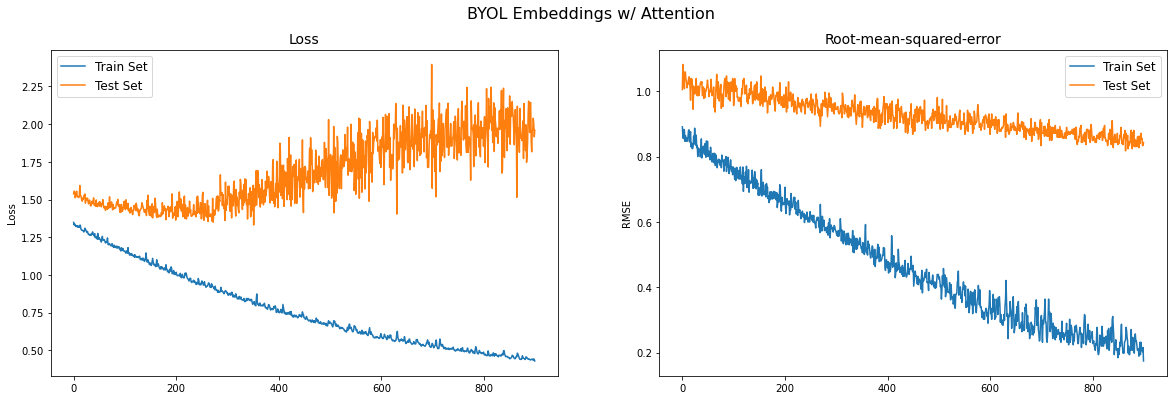

In [34]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)
fig.suptitle("BYOL Embeddings w/ Attention", fontsize=16)
ax[0].plot(byol_attention_data["train_loss"], label="Train Set")
ax[0].plot(byol_attention_data["val_loss"], label="Test Set")
ax[0].legend(fontsize=12)
ax[0].set_title("Loss", fontsize=14)
ax[0].set_ylabel("Loss")
ax[1].plot(byol_attention_data["train_rmse"], label="Train Set")
ax[1].plot(byol_attention_data["val_rmse"], label="Test Set")
ax[1].legend(fontsize=12)
ax[1].set_title("Root-mean-squared-error", fontsize=14)
ax[1].set_ylabel("RMSE")

One quite interesting facet of training is that while the RMSE continues to fall for the test set, its loss does not. Obviously the loss function of not the same as RMSE, but it seems counterintuitive that the loss increases along with the model's performance. 

Text(0, 0.5, 'RMSE')

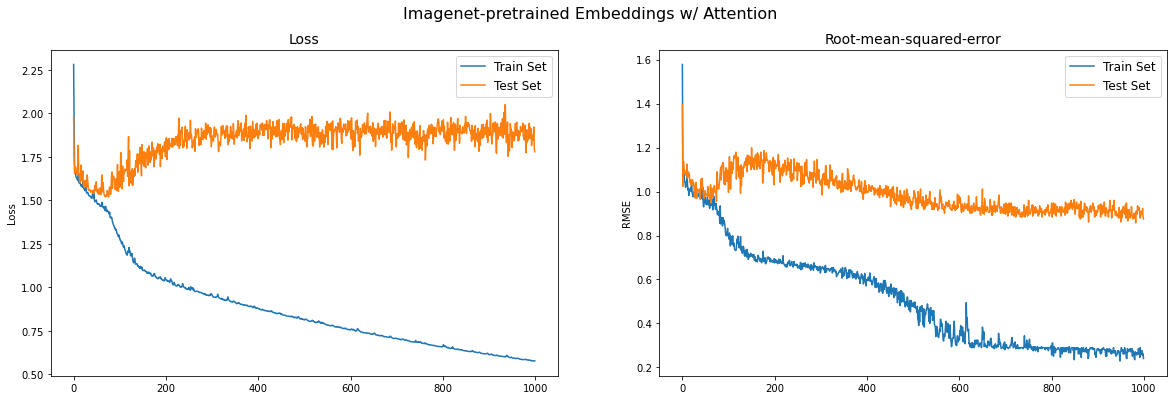

In [28]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(20, 6)
fig.suptitle("Imagenet-pretrained Embeddings w/ Attention", fontsize=16)
ax[0].plot(pt_attention_data["train_loss"], label="Train Set")
ax[0].plot(pt_attention_data["val_loss"], label="Test Set")
ax[0].legend(fontsize=12)
ax[0].set_title("Loss", fontsize=14)
ax[0].set_ylabel("Loss")
ax[1].plot(pt_attention_data["train_rmse"], label="Train Set")
ax[1].plot(pt_attention_data["val_rmse"], label="Test Set")
ax[1].legend(fontsize=12)
ax[1].set_title("Root-mean-squared-error", fontsize=14)
ax[1].set_ylabel("RMSE")

As demonstrated by the above plots, the models trained effectively.

#### Comparison

In previous experiments, we used an average pooling strategy paired with several different regression methods. The highest performing method was ordinal ridge regression on average pooled BYOL embeddings, scoring an RMSE of **0.81**.

Text(0, 0.5, 'RMSE')

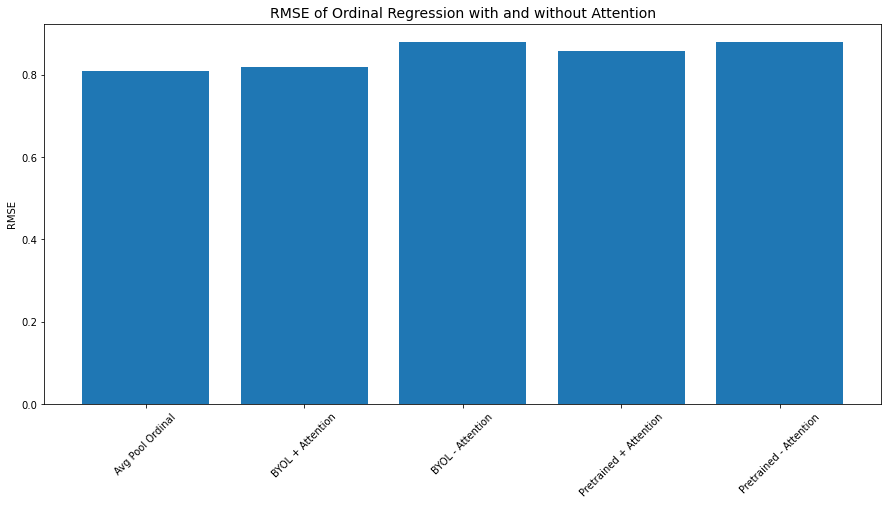

In [53]:
best_byol_att = min(byol_attention_data["val_rmse"])
best_im_att = min(pt_attention_data["val_rmse"])
best_byol_noatt = 0.88
best_im_noatt = 0.88
best_prev = 0.81

labels = ['Avg Pool Ordinal', 'BYOL + Attention', 'BYOL - Attention', 'Pretrained + Attention', 'Pretrained - Attention']
data = [best_prev, best_byol_att, best_byol_noatt, best_im_att, best_im_noatt]

fig = plt.figure();
fig.set_size_inches(15,7)
plt.bar(labels, data);
plt.xticks(rotation=45, horizontalalignment='center');
plt.title('RMSE of Ordinal Regression with and without Attention', fontsize=14)
plt.ylabel('RMSE')

Our attention models performs about on par with our previous best effort. 